[link text](https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54?permalink_comment_id=3462316)

# GRAD-CAM  

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

#https://docs.opencv.org/4.x/d3/d50/group__imgproc__colormap.html
    def overlay_heatmap(self, heatmap, image, alpha=None,
                        colormap=cv2.COLORMAP_JET ):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1-alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

# Resized function
[link text](https://medium.com/jungletronics/opencv-resize-an-image-54df7680e828)

217 352


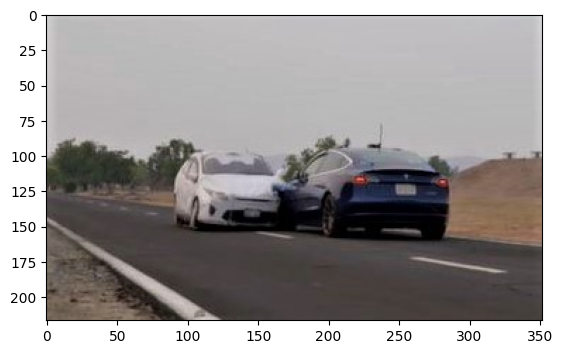

In [ ]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# reload everything
img = cv2.imread('/content/img3.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
i = plt.imshow(img, cmap='gray')
img.shape
# Saving height(h) for variable h, and length for w
# Use Tuple unpacking tecnique
h, w = img.shape[:2]
print(h, w)

The original aspect ratio is 1.62
h=20, new_w=32
The new aspect ratio is still 1.62
With this math we proportionally convert the image to 200 x 200


True

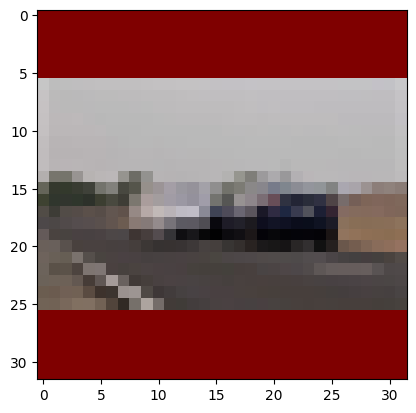

In [ ]:
#RESIZED INPUT OF THE MODEL
size = (32,32)
sh, sw = size

# interpolation method
if h > sh or w > sw: # shrinking image
   interp = cv2.INTER_AREA
else: # stretching image
   interp = cv2.INTER_CUBIC
# aspect ratio of image
aspect = w/h
print(f"The original aspect ratio is {aspect:.3}")

# compute scaling and pad sizing
if aspect > 1: # horizontal image
  new_w = sw
  new_h = np.round(new_w/aspect).astype(int)
  pad_vert = (sh-new_h)/2
  pad_top, pad_bot = np.floor(pad_vert).astype(int),np.ceil(pad_vert).astype(int)
  pad_left, pad_right = 0, 0
print(f"h={new_h}, new_w={new_w}")
# Recalc the aspect ratio
aspect = w/h
print(f"The new aspect ratio is still {aspect:.3}")
print("With this math we proportionally convert the image to 200 x 200")

scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=127)
i = plt.imshow(scaled_img, cmap='gray')
scaled_img.shape
cv2.imwrite('/content/resized_input_3.jpeg', scaled_img)

The original aspect ratio is 1.62
h=62, new_w=100
The new aspect ratio is still 1.62
With this math we proportionally convert the image to 200 x 200


True

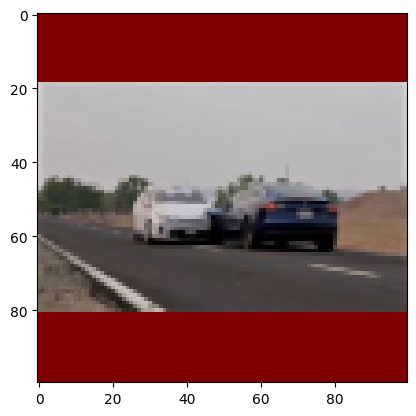

In [ ]:
# COMPARE RESIZED IMAGE WITH HEATMAP
size = (100,100)
sh, sw = size

# interpolation method
if h > sh or w > sw: # shrinking image
   interp = cv2.INTER_AREA
else: # stretching image
   interp = cv2.INTER_CUBIC
# aspect ratio of image
aspect = w/h
print(f"The original aspect ratio is {aspect:.3}")

# compute scaling and pad sizing
if aspect > 1: # horizontal image
  new_w = sw
  new_h = np.round(new_w/aspect).astype(int)
  pad_vert = (sh-new_h)/2
  pad_top, pad_bot = np.floor(pad_vert).astype(int),np.ceil(pad_vert).astype(int)
  pad_left, pad_right = 0, 0
print(f"h={new_h}, new_w={new_w}")
# Recalc the aspect ratio
aspect = w/h
print(f"The new aspect ratio is still {aspect:.3}")
print("With this math we proportionally convert the image to 200 x 200")

scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=127)
i = plt.imshow(scaled_img, cmap='gray')
scaled_img.shape
cv2.imwrite('/content/compare_image_3.jpeg', scaled_img)

# Heat-Map Visualization

(32, 32, 3)
(1, 32, 32, 3)
1/1 [==============================] - 0s 21ms/step


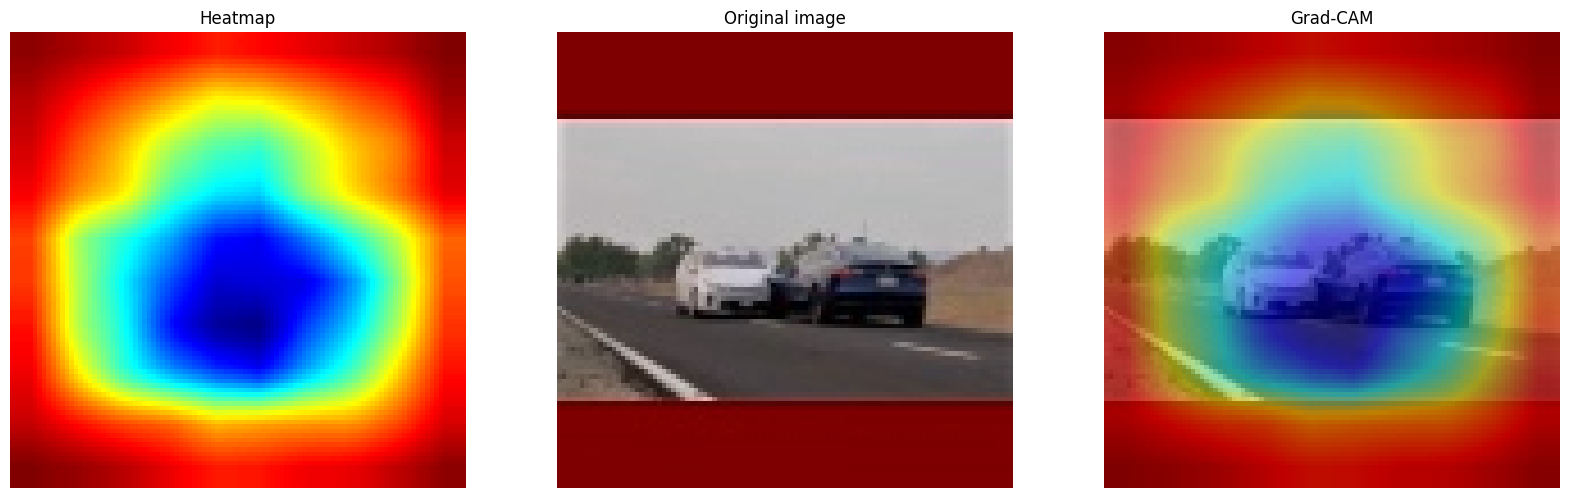

In [ ]:
image = cv2.imread('/content/resized_input_3.jpeg') # 32,32 SIZE OF INPUT THE MODEL
print(image.shape)

image = tf.divide(image, 255)
image = np.expand_dims(image, axis=0)
print(image.shape)
preds = model.predict(image)
i = np.argmax(preds[0])

icam = GradCAM(model, i, 'Layer_name')

heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (100,100))
image = cv2.imread('/content/compare_image_3.jpeg') # 100,100 SIZE OF COMPARISON WITH HEATMAP
(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20,20)

ax[0].imshow(heatmap)
ax[0].set_title('Heatmap')
ax[0].axis('off')

ax[1].imshow(image)
ax[1].set_title('Original image')
ax[1].axis('off')

ax[2].imshow(output)
ax[2].set_title('Grad-CAM')
ax[2].axis('off')

plt.show()